In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# 1. Business understanding

If you have one or part of your house that is idled, it is not a bad idea to share it with someone in need and earn some revenue from it. However, before doing this, you need to make sure to understand the market and make wise decisions based on your situation.

In this project, I am going to answer some questions which potential AirBnB hosts are interested to know. The answers are based on the anlysis from Seattle AirBnB’s 2016 home data. The questions include:

- when to rent to maximize the revenue?
- when is the off-peak season for maintenance?
- what is the most popular home type?
- where is the most popular location?
- how to achieve a good rating?


# 2. Data understanding
Get a glimpse of the data in order to know the information that is contained in the data and picture the type of analysis and corresponding steps to be carried out.

In [2]:
# read the data set
df_calendar = pd.read_csv('./AirBnB_Seattle/calendar.csv')
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


- The calendar data includes the 'date' and 'availability' types which need to be transformed into numerical data
- The price infomation has more than 400K missing values

In [3]:
# read the data set
df_listings = pd.read_csv('./AirBnB_Seattle/listings.csv')
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

- the listing data has a lot of info, which is promising to provide sufficient information for a potential host
- there are many categorical data types which need to be handled properly

In [4]:
# read the data set
df_reviews = pd.read_csv('./AirBnB_Seattle/reviews.csv')
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84832 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


- the review data has some null in the comments

# 3. Prepare Data

- prepare review data

In [5]:
# remove reviews with no comments
df_reviews = df_reviews.dropna(subset=['comments'],axis=0)

- prepare calendar data

In [6]:
df_calendar['price']=df_calendar['price'].replace('[\$,]', '', regex=True).astype(float)
# impute price info with the mode
df_calendar['price'].fillna(df_calendar['price'].mode()[0], inplace=True)

df_calendar['date']=pd.to_datetime(df_calendar['date'])
df_calendar['dayofweek']=df_calendar['date'].dt.dayofweek
df_calendar['month']=df_calendar.date.dt.month
df_calendar['year']=df_calendar.date.dt.year

 - prepare listing data

In [7]:
# function to transform special number format to numeric number
def to_numeric_number(df, list_of_column_names, special_sign):
    for col_name in list_of_column_names:
        df[col_name]=pd.to_numeric(df_listings[col_name].apply(lambda x: str(x).replace(special_sign, '').replace(',', '')),errors='coerce')
    return df 
        
        

In [8]:
# rename column name
df_listings=df_listings.rename(columns={'id':'listing_id'})

# transform special number format to numeric number
list_of_column_names = ['monthly_price', 'price', 'weekly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
df_listings=to_numeric_number(df_listings, list_of_column_names, '$')

# change to datetime
df_listings['host_since']=pd.to_datetime(df_listings['host_since'])
df_listings['month']=df_listings.host_since.dt.month
df_listings['year']=df_listings.host_since.dt.year

In [9]:
# merge data
df_calendar_listing=df_listings.merge(df_calendar,on='listing_id')

 - Deal with interested categorical data in the listing

In [10]:
#Create dummy columns for all the categorical variables in df_listings, drop the original columns
cat_vars = list(['host_acceptance_rate', 'host_is_superhost', 'host_verifications',\
                 'cancellation_policy','smart_location'])

# cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in cat_vars:
    df_listings = pd.concat([df_listings.drop(var, axis=1), pd.get_dummies(df_listings[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    

# 5. Data modeling

In this project, machine learning is not used to create a model from the data as all the questions can be answered through the data itself and no prediction is necessary at this time.

# 6. Evaluate the results

In this section, I am providing my analysis based on the data. My analysis is motivated by the business question (proposed in the first section) and follows each corresponding questions with conclusions/answers.

## Q1: when to rent to maximize the revenue?

## Q2: when is the off-peak season for maintenance?

Analyze the price differences by the day of the week, and the date/month of the year to get an answer.

In [11]:
price_by_date=df_calendar.groupby('date')[['price']].mean()

(array([16804, 16832, 16861, 16892, 16922, 16953, 16983, 17014, 17045,
        17075, 17106, 17136, 17167, 17168]),
 <a list of 14 Text xticklabel objects>)

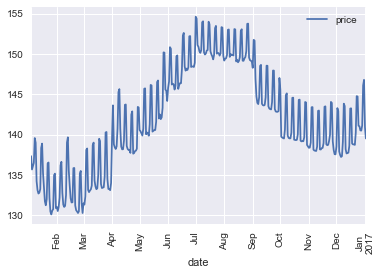

In [12]:
price_by_date.plot()
plt.xticks(rotation=90)

### Conclusions
- the daily average price shows higher rental price during Jul - Sep 
- local short-term oscillations are abundant, which indicates a regular price change trend during each week

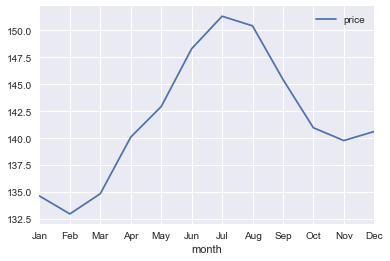

In [13]:
price_by_month=df_calendar.groupby('month')[['price']].mean()
price_by_month.plot()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.savefig("price_month.png", bbox_inches = 'tight')

### Conclusions
- the above figure shows the average price by month (long term trend)
- this shows Jun - Aug reach higher rent than the rest of the year, so hosts may choose to list more during these months to get more revenue
- on the contrary, Dec - Feb are probably the best months for maintenance

In [14]:
price_by_weekday=df_calendar.groupby('dayofweek')[['price']].mean()

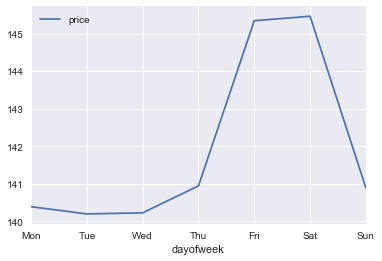

In [15]:
price_by_weekday.plot()
plt.xticks(range(0,7),['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.savefig("price_dayofweek.png", bbox_inches = 'tight')

### Conclusions
- the above figure shows the average price by week (short term trend)
- it can be seen the price is higher on Fridays and Saturdays, however, the raise is not very large (~$10)

(array([  1.33900000e+03,   1.60000000e+03,   4.52000000e+02,
          2.18000000e+02,   7.50000000e+01,   7.20000000e+01,
          2.40000000e+01,   1.20000000e+01,   1.20000000e+01,
          1.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   4.00000000e+00]),
 array([   20.        ,    85.33333333,   150.66666667,   216.        ,
          281.33333333,   346.66666667,   412.        ,   477.33333333,
          542.66666667,   608.        ,   673.33333333,   738.66666667,
          804.        ,   869.33333333,   934.66666667,  1000.        ]),
 <a list of 15 Patch objects>)

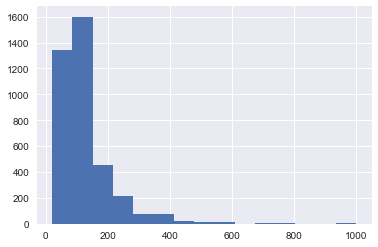

In [16]:
plt.hist(df_listings['price'],bins=15)

### Conclusion
- most listing prices are between \$0 - \$200

## Q3: where is the most popular location?

The potential host may be interested in whether their property is in a popular location that is suitable for renting. Answer this question by looking at the neighborhood data from the listing info.

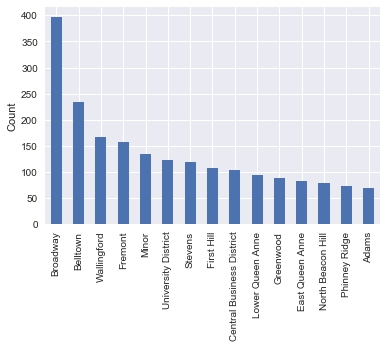

In [17]:
df_listings['neighbourhood_cleansed'].value_counts().head(15).plot(kind='bar')
plt.ylabel("Count")
plt.savefig("neighbourhood_count.png", bbox_inches = 'tight')

### Conclusion
- it can be seen the neighborhood that has the most listings are Broadway, followed by Belltown and wailingford

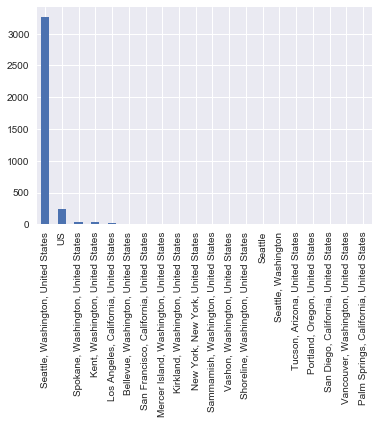

In [18]:
df_listings['host_location'].value_counts().head(20).plot(kind='bar')

### Conclusion
- also, the hosts are mostly local (from Seattle)

## Q4: what is the most popular home type?

The host may be interested to know if their property type is suitable for renting. Answer this question by looking at the listing info.

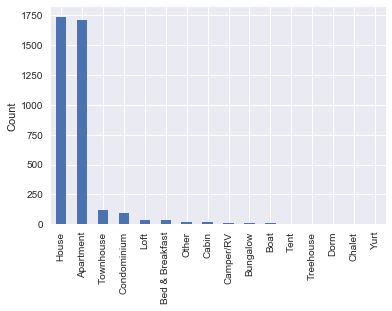

In [19]:
df_listings['property_type'].value_counts().head(20).plot(kind='bar')
plt.ylabel("Count")
plt.savefig("property_type_count.png", bbox_inches = 'tight')

### Conclusion
- the most popular property types are house and apartments

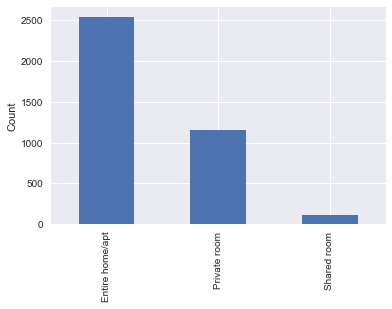

In [20]:
df_listings['room_type'].value_counts().head(20).plot(kind='bar')
plt.ylabel("Count")
plt.savefig("room_type_count.png", bbox_inches = 'tight')

### Conclusion
- the entire home/apartment is the most popular, followed by private room

([<matplotlib.axis.XTick at 0x11ed355c0>,
 <a list of 12 Text xticklabel objects>)

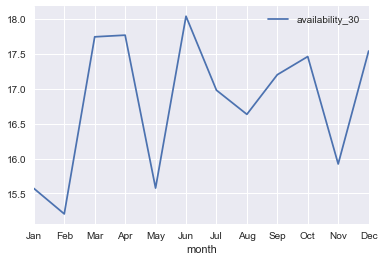

In [21]:
avail_30=df_listings.groupby('month')[['availability_30']].mean()
avail_30.plot()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

### Conclusion
- the monthly availability has many fluctuations during the year
- the most avaiable months are Mar, Apr, and Jun

## Q5: how to achieve a good rating?

As a host, you would want to increase the review score in order to be seen by more customers. In order to do so, we need to know what affects the review score. To answer this question, I am looking into the listing and review data.

- Does property type, accomedates, amenities, square_feet, bathrooms, bedrooms, and beds  affect review score?

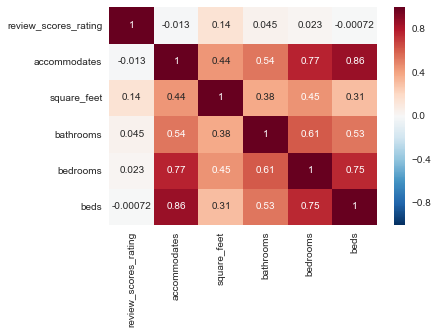

In [22]:
sns.heatmap(
    df_listings[[
        'review_scores_rating',\
        'property_type', 'accommodates',\
        'amenities', 'square_feet',\
        'bathrooms', 'bedrooms', 'beds',\
                 ]].corr(),annot=True
)

plt.savefig("review_room.png", bbox_inches = 'tight')

### Conclusion
- square_feet slightly positively affects the review score
- other factors does not seem to affect the review score much

- Does host info affect the review score?

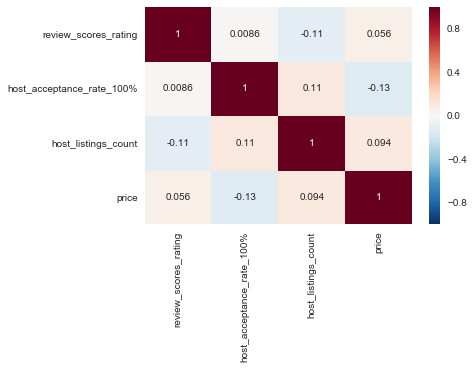

In [23]:
sns.heatmap(
    df_listings[[
        'review_scores_rating', 'host_acceptance_rate_100%',\
        'host_response_time', 'host_response_rate',\
        'host_listings_count', 'price'\
                 ]].corr(),annot=True
)

plt.savefig("review_host.png", bbox_inches = 'tight')

### Conclusion
- host listings count seems to negativelly affect the review score

- Does (short/long term) availability affect the review score?

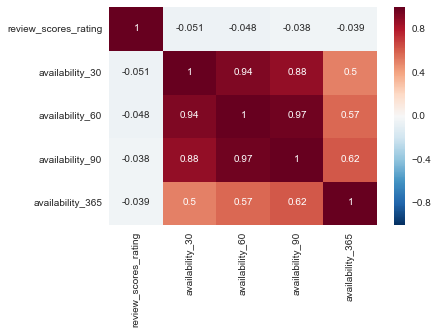

In [24]:
sns.heatmap(
    df_listings[[
        'review_scores_rating', \
        'availability_30', 'availability_60',\
        'availability_90', 'availability_365',\
                 ]].corr(),annot=True
)

plt.savefig("review_availability.png", bbox_inches = 'tight')

### Conclusion
- availability does not affect the review score much

- Do cancellation policy and smart location affect rating?

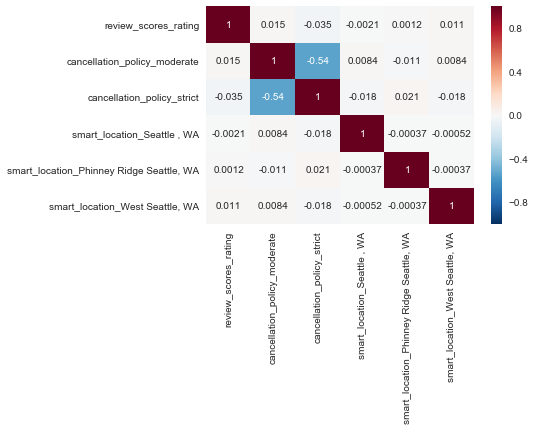

In [25]:
sns.heatmap(
    df_listings[[
        'review_scores_rating',\
        'cancellation_policy_moderate', 'cancellation_policy_strict',\
        'smart_location_Seattle , WA', 'smart_location_Phinney Ridge Seattle, WA',\
        'smart_location_West Seattle, WA',\
                 ]].corr(),annot=True
)

plt.savefig("review_cancellation_smart_loc.png", bbox_inches = 'tight')

### Conclusion
- these factors do not seem to affect review score much

### More conclusion to Q5
- There does not seem to be a strong dependency of the review score to many factors. For example,  the amenities, bedrooms, beds, availability, host acceptance rate, long/short term availabilities, cancellation policy, or whether the property is in a smart location.

- It is a complicated task to increase the review score. Data from more reviewers during a longer time period maybe more helpful for this analysis.